# Simulating a print
In this first tutorial, we will walk you through how to use Dr.TVAM to simulate a print from a set of patterns.

<div class="admonition important alert alert-block alert-success">

🚀 **We will cover the following topics:**
    
<ul>
  <li>The different components of the system: resin container, projection system and sensor</li>
  <li>How to set up a scene to run the simulation</li>
  <li>Run the simulation and look at the results</li>
</ul>
    
</div>


We start by importing `drtvam`  along with other packages:

In [1]:
import drtvam
import mitsuba as mi
import drjit as dr
import numpy as np
import matplotlib.pyplot as plt

## 1. Describing the experimental setup

Dr.TVAM is built on [Mitsuba 3](https://mitsuba.readthedocs.io/en/stable/index.html), and therefore uses a similar paradigm to run light transport simulations. The optical setup is defined as a *scene* which contains information about all the surfaces and the printing medium, as well as the description of the projection setup, and a *sensor* that records absorbed energy in the medium. This scene is then provided by an *integrator* that runs the simulation to write to the sensor the absorbed energy in the sensor. Conforming with computer graphics semantics, we call this operation *rendering*.

The first step to using Dr.TVAM is therefore to setup this scene. This is done by building a dictionary description, and letting Mitsuba 3 load it.

This dictionnary needs to describe the following elements:
- **The resin container**. Its role is twofold:
    - describe the shape of the container (e.g. a cylindrical vial, with a given radius) and its optical properties
    - describe the parameters of the printing medium: extinction coefficient, single-scattering albedo and phase function.
- **The projection system**. This describes how the patterns are projected onto the vial. It has two independent aspects:
    - What is the optical projection model ? We support collimated and perspective projections.
    - How does the projection moves relative to the container as a function of time?
- **The sensor**. Its location and size determines what we will be measuring. 

We will start with an empty scene. This is specified by adding the 'scene' type tag. We will add the necessary components one by one.

In [2]:
scene_dict = {'type': 'scene'}

### Container geometry

Containers are implemented as child classes of the `Container` class. They can be instantiated using a dictionary of parameters, and they implement a `to_dict` method that will generate the necesary representation to fill the scene representation.

In this scene, we will consider a simple cylindrical vial, without index matching bath, which is implemented by the `CylindricalVial` plugin. We will need to specify its interior and exterior radii, its height and index of refraction.

The `Container` class also expects a 'medium' dictionary containing the following information:
- index of refraction
- extinction coefficient
- single-scattering albedo
- phase function

The extinction coefficient measures the total loss of energy along a ray, as measured in a spectrophotometer. The single-scattering albedo is a quantity in $[0,1]$ that quantifies the ratio of the *scattering* coefficient to *extinction*. An albedo of 0.0 corresponds to a purely absorptive medium, and an albedo of 1.0 corresponds to a purely scattering one. Note that the latter doesn't make sense in the context of TVAM, as we record *absorbed* energy in the volume, which would therefore be zero everywhere.

Scene scale is arbitrary, as long as all physical quantities are consistent with it. Here, we will consider the unit to be the millimeter. Therefore, medium coefficients will be expressed in $\text{mm}^{-1}$ and vial dimensions in $\text{mm}$

The specific keys in the container parameter dictionnary depend on the particular container. Please see the documentation for more details.

In [3]:
vial_params = {
    'r_int': 5., # 10mm interior diameter
    'r_ext': 5.5, # 11mm exterior diameter
    'ior': 1.54, # Index of refraction of the vial
    'medium': {
        'ior': 1.5, # Index of refraction of the resin
        'extinction': 0.1, # Extinction coefficient
        'albedo': 0. # Purely absorptive
    }
}

vial = drtvam.geometry.CylindricalVial(vial_params)

We can then call the `to_dict` method to generate the Mitsuba-compatible description, and concatenate it with the main scene representation:

In [4]:
scene_dict |= vial.to_dict()

### Projector

Next, we can setup the projector. This is made up of two components: the projection model (`collimated` or `perspective`), and the motion of the projector in the scene. 

<div class="admonition important alert alert-block alert-info">

🗒 **Note**

In the real world, the resin container is most likely mounted on some sort of rotation stage, and the optical system is immobile. However, it is more efficient to implement it the other way around, where the projector moves around an immobile container. This is perfectly equivalent, however one needs to be mindful of this when trying to match a real printing setup. For example, if the vial rotates clockwise in the real world, then the projector needs to rotate *counter*-clockwise in the simulation setup.

</div>

We will use a collimated projector, with a simple rotation around the axis of the vial. We will demonstrate more complicated options in later tutorials.

Unlike the vial, the projector is directly described in the scene dicsionary. The motion is described in a nested dictionary.

The projector stores the light patterns. There are several ways to set those, but for the moment we will directly pass a tensor containing some manually crafted patterns as argument. The convention used is that the shape of the tensor is $(n_\text{patterns}, \text{height}, \text{width})$. We will see in the next tutorial how those can be optimized.

One should also specify the physical pixel size in the printing plane.

For the motion, we will use a simple circular motion around the axis of the vial, and set the distance to be $20\text{mm}$ away from the rotation axis.

In [5]:
patterns = np.zeros((100, 128, 128)) # 100 angles at 128x128 resolution
patterns[..., 32:-32, 16:48] = 1.0
patterns[..., 32:-32, -48:-16] = 1.0

We visualize one of the patterns below:

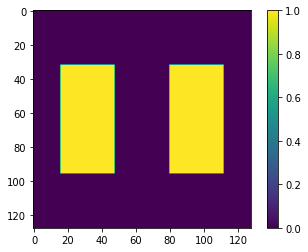

In [6]:
plt.imshow(patterns[0], cmap='viridis')
plt.colorbar()

In [7]:
scene_dict['projector'] = {
    'type': 'collimated',
    'patterns' : patterns,
    'pixel_size': 0.1,
    'motion': 'circular',
    'distance': 20.
}

### Sensor

The sensor measures the absorbed light in the medium. It is essentially a regular 3D grid, whose position in space and resolution can be specified arbitrarily.
There are several sensors available in Dr.TVAM, but we recommend using the `DDA` sensor, as it produces the highest-quality results.The sensor resolution is specified in the `film` nested dictionary, with one entry for the resolution along each axis. The sensor's scale and position in space is specified by the `to_world` field, which specifies a rigid transform [matrix](https://mitsuba.readthedocs.io/en/stable/src/api_reference.html#mitsuba.ScalarTransform4f). By default, the sensor covers the unit cube $[-0.5, 0.5]^3$, and the rigid transform is applied to that cube.

In [8]:
scene_dict['sensor'] = {
    'type': 'dda',
    'to_world': mi.ScalarTransform4f().scale(10),
    'film': {
        'type': 'vfilm',
        'resx': 128,
        'resy': 128,
        'resz': 128,
    }
}

this concludes the scene description, the result is a dictionary representation that can be understood by Mitsuba:

In [9]:
scene = mi.load_dict(scene_dict)

## 2. Loading the integrator

The second element of simulating a print is then to load the integrator. This is done again by specifying a dictionary representation. This integrator should be of the `volume` type, and expects some parameters:
- `max_depth`: The integrator simulates *light paths* from the projector to the printing medium. The *depth* of a path denotes the number of scattering events (at surfaces or in the medium) it undergoes. This parameter defines how many scattering events are simulated before ending a path. For a purely absorptive medium, it is often sufficient to set it to 3. Scattering media will require a longer maximum depth to simulate medium scattering events.
- `print_time`: This defines the total exposure time, in seconds.

A few more advanced parameters are available, please see the documentation for more details.

In [10]:
integrator = mi.load_dict({
    'type': 'volume',
    'max_depth': 3,
    'print_time': 10 # 10s print
})

## 3. Rendering

We are now ready to simulate the print. We do so by calling Mitsuba's `render` operation. It can take several arguments:
- `scene`: the scene description we have created above.
- `integrator`: the integrator used to run the simulation.
- `spp`: **S**amples **P**er **P**ixel. This parameter determines how many paths are generated per projector pixel.
- `seed`: determines the seed that will be used by the  random number generator when random events occur, e.g. medium scattering.

The result is a 3D sensor that contains the simulated absorption in the sensor.

In [11]:
result = mi.render(scene, integrator=integrator, spp=64, seed=0)

## 4. Visualizing the results
We can now visualize slices of the result, using matplotlib. In particular, we can choose a threshold to simulate how the print would turn out after polymerization.

(-0.5, 127.5, 127.5, -0.5)

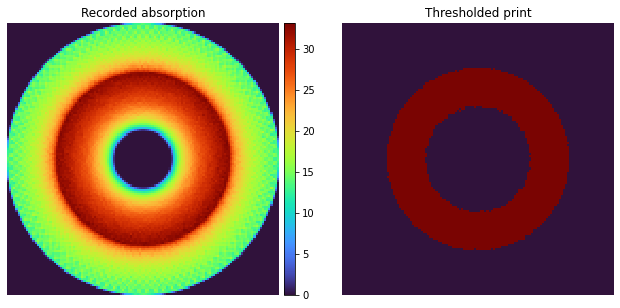

In [12]:
fig = plt.figure(1, figsize=(11, 5))
gs = fig.add_gridspec(1, 2, wspace=0.2)

ax = fig.add_subplot(gs[0])
im = ax.imshow(result[64], interpolation='none', cmap='turbo')
ax.set_title("Recorded absorption")
cbax = ax.inset_axes([1.02, 0, 0.04, 1], transform=ax.transAxes)
fig.colorbar(im, cax=cbax)
ax.axis('off')

ax = fig.add_subplot(gs[1])
ax.imshow(result[64] > 25, interpolation='none', cmap='turbo')
ax.set_title("Thresholded print")
ax.axis('off')